# 4D emittance measurement data analysis 

In [1]:
import sys
import os
import copy
import importlib
from tqdm import trange, tqdm

import numpy as np
import pandas as pd
from scipy import optimize as opt
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import animation
import proplot as pplt
import seaborn as sns

sys.path.append('/Users/46h/Research/')
from accphys.tools import beam_analysis as ba
from accphys.tools import coupling as BL
from accphys.tools import plotting as myplt
from accphys.tools import utils
from accphys.tools.accphys_utils import V_matrix_4x4_uncoupled, phase_adv_matrix

from accphys.emittance_measurement_4D.analysis import reconstruct
from accphys.emittance_measurement_4D.analysis import to_mat, to_vec
from accphys.emittance_measurement_4D.plotting import reconstruction_lines

In [2]:
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid.alpha'] = 0.04
pplt.rc['axes.grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['savefig.transparent'] = False
pplt.rc['savefig.dpi'] = 'figure'
pplt.rc['animation.html'] = 'jshtml'

In [3]:
eps_labels = [r'$\varepsilon_x$', r'$\varepsilon_y$', 
              r'$\varepsilon_1$', r'$\varepsilon_2$']
savefig_kws = dict(facecolor='white', dpi=300)

## Load data 

In [4]:
folder = './_saved/2021-09-26/setting1/ramp_turns/'

# We can restrict the number of measurements used if we want.
max_n_meas = 100 

# We can exclude certain wire-scanners if we want.
exclude = None

In [5]:
utils.delete_files_not_folders('_output/figures/')

In [6]:
def load_data_dict(filename, ndarray=True):
    dictionary = dict()
    file = open(filename, 'r')
    for line in file:
        tokens = line.rstrip().split(' ')
        ws_id = tokens[0]
        items = [float(token) for token in tokens[1:]]
        if ws_id not in dictionary:
            dictionary[ws_id] = []
        dictionary[ws_id].append(items)
    file.close()
    dictionary = utils.blacklist(dictionary, exclude)
    for ws_id in dictionary:
        if max_n_meas:
            dictionary[ws_id] = dictionary[ws_id][:max_n_meas]
        if ndarray:
            dictionary[ws_id] = np.array(dictionary[ws_id])
    return dictionary

In [7]:
tmats_dict = load_data_dict(os.path.join(folder, 'info/transfer_mats.dat'), ndarray=False)
moments_dict = load_data_dict(os.path.join(folder, 'info/moments.dat'))
phases_dict = load_data_dict(os.path.join(folder, 'info/phase_adv.dat'))
pos_x_dict = load_data_dict(os.path.join(folder, 'info/pos_x.dat'))
pos_y_dict = load_data_dict(os.path.join(folder, 'info/pos_y.dat'))
pos_u_dict = load_data_dict(os.path.join(folder, 'info/pos_u.dat'))
raw_x_dict = load_data_dict(os.path.join(folder, 'info/raw_x.dat'))
raw_y_dict = load_data_dict(os.path.join(folder, 'info/raw_y.dat'))
raw_u_dict = load_data_dict(os.path.join(folder, 'info/raw_u.dat'))

ws_ids = sorted(list(tmats_dict))
n_meas = len(tmats_dict[ws_ids[0]])
meas_indices = list(range(n_meas))

# Convert from 16 element lists to 4x4 arrays for transfer matrices.
for ws_id in ws_ids:
    for i in range(n_meas):
        tmats_dict[ws_id][i] = np.reshape(tmats_dict[ws_id][i], (4, 4))

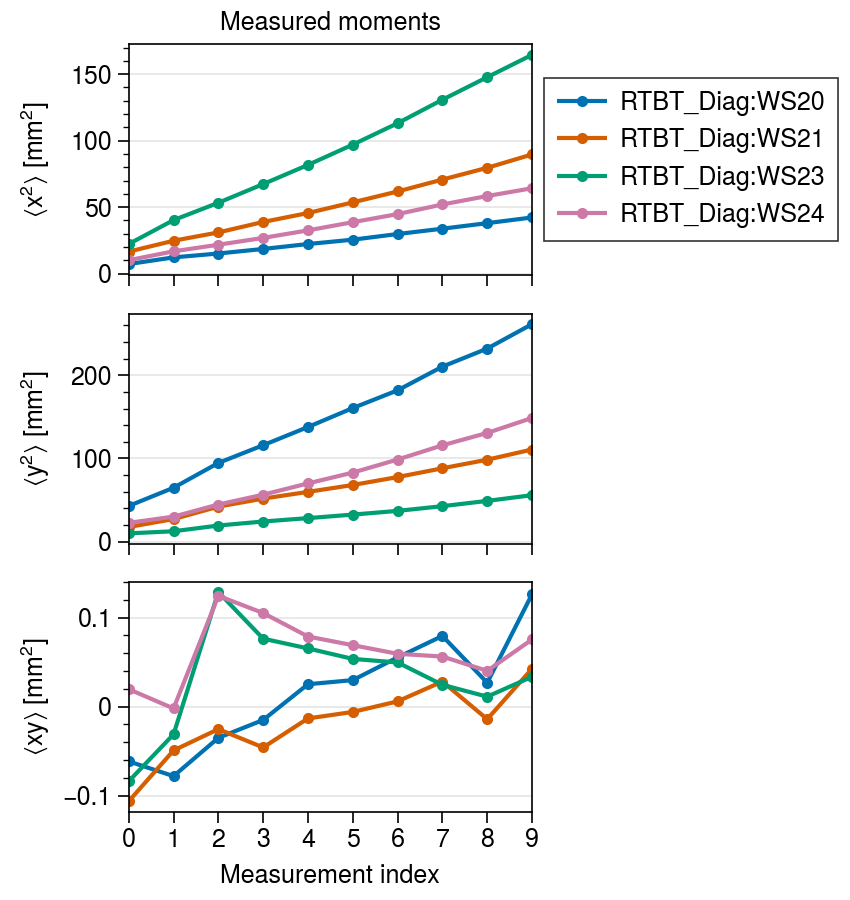

In [8]:
fig, axes = pplt.subplots(nrows=3, figsize=(4.25, 4.5), spany=False, wspace=1, aligny=True)
plt_kws = dict(marker='.')
handles = []
for ws_id in ws_ids:
    moments = moments_dict[ws_id]
    axes[0].plot(moments[:, 0], **plt_kws)
    axes[1].plot(moments[:, 1], **plt_kws)
    h = axes[2].plot(moments[:, 2] / np.sqrt(moments[:, 0] * moments[:, 1]), **plt_kws)
    handles.append(h)
axes[0].format(ylabel=r'$\langle{x^2}\rangle$ [mm$^2$]')
axes[1].format(ylabel=r'$\langle{y^2}\rangle$ [mm$^2$]')
axes[2].format(ylabel=r'$\langle{xy}\rangle$ [mm$^2$]')
for ax in axes:
    ax.grid(axis='y', alpha=0.1)
axes.format(xlabel='Measurement index', xtickminor=False, xticks=meas_indices)
axes[0].legend(handles, labels=ws_ids, ncols=1, loc='r', fontsize='small')
axes[0].set_title('Measured moments', fontsize='medium')
plt.savefig('_output/figures/moments.png', **savefig_kws)

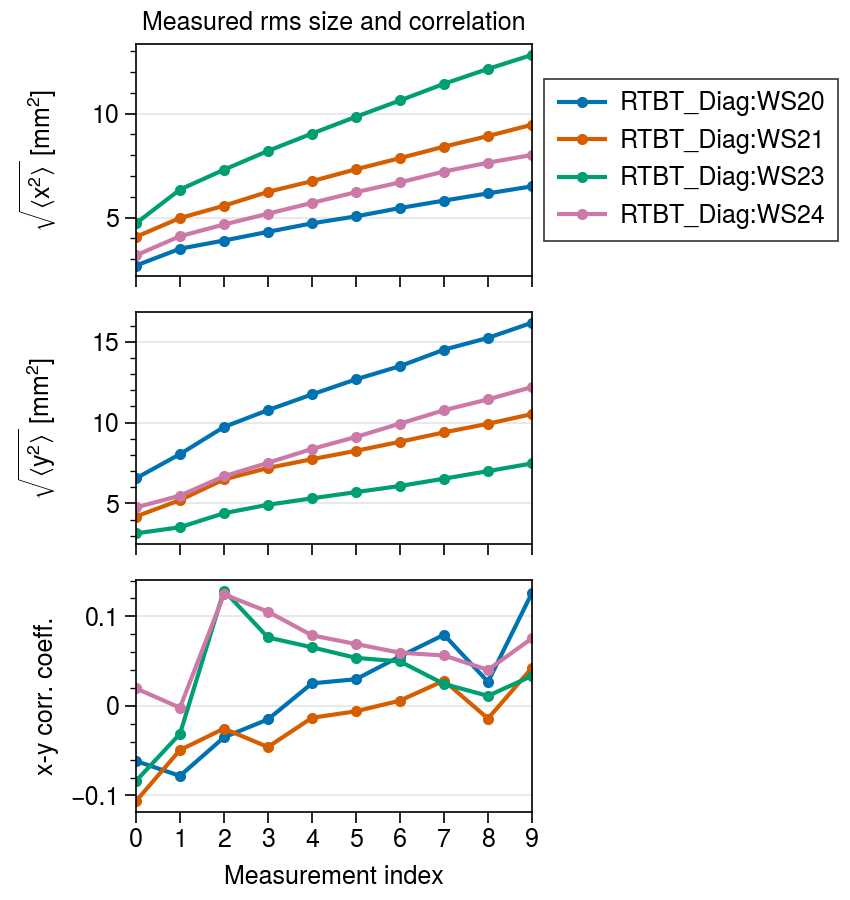

In [9]:
fig, axes = pplt.subplots(nrows=3, figsize=(4.25, 4.5), spany=False, wspace=1, aligny=True)
handles = []
for ws_id in ws_ids:
    moments = moments_dict[ws_id]
    axes[0].plot(np.sqrt(moments[:, 0]), **plt_kws)
    axes[1].plot(np.sqrt(moments[:, 1]), **plt_kws)
    h = axes[2].plot(moments[:, 2] / np.sqrt(moments[:, 0] * moments[:, 1]), **plt_kws)
    handles.append(h)
axes[0].format(ylabel=r'$\sqrt{\langle{x^2}\rangle}$ [mm$^2$]')
axes[1].format(ylabel=r'$\sqrt{\langle{y^2}\rangle}$ [mm$^2$]')
axes[2].format(ylabel=r'x-y corr. coeff.')
for ax in axes:
    ax.grid(axis='y', alpha=0.1)
axes.format(xlabel='Measurement index', xtickminor=False, xticks=meas_indices)
axes[0].legend(handles, labels=ws_ids, ncols=1, loc='r', fontsize='small')
axes[0].set_title('Measured rms size and correlation', fontsize='medium')
plt.savefig('_output/figures/size_corr.png', **savefig_kws)

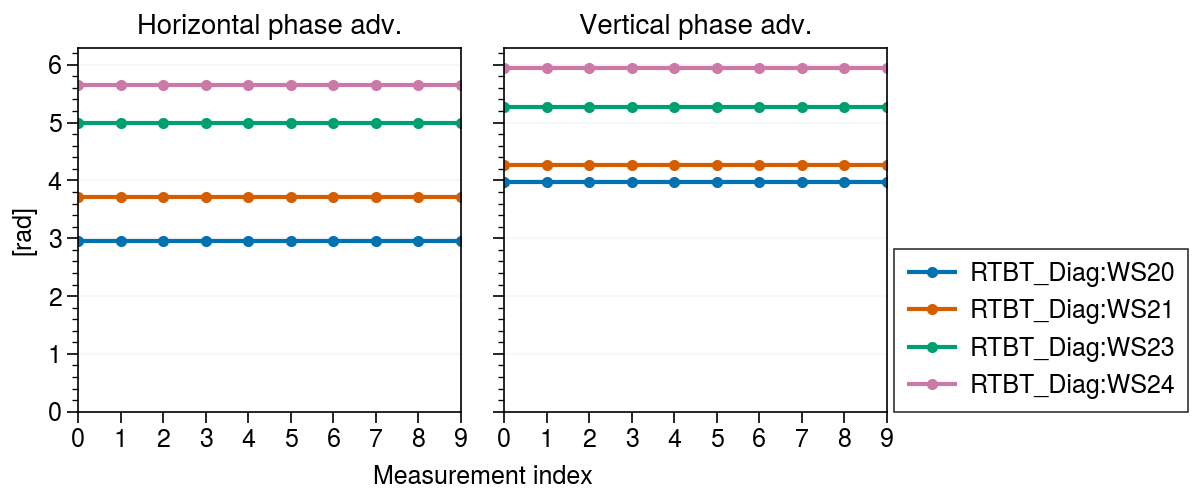

In [10]:
fig, axes = pplt.subplots(ncols=2, figsize=(6, 2.5))
handles = []
for ws_id in ws_ids:
    mux, muy = phases_dict[ws_id].T
    axes[0].plot(mux, **plt_kws)
    h = axes[1].plot(muy, **plt_kws)
    handles.append(h)
axes.format(xlabel='Measurement index', ylabel='[rad]', ylim=(0, 2 * np.pi),
            xtickminor=False, xticks=range(n_meas))
axes[0].set_title('Horizontal phase adv.')
axes[1].set_title('Vertical phase adv.')
axes[1].legend(handles, ws_ids, ncols=1, loc=(1.02, 0), fontsize='small')
for ax in axes:
    ax.grid(axis='y')
plt.savefig('_output/figures/phases.png', **savefig_kws)

In [11]:
# fig, axes = pplt.subplots(ncols=3)
# colors = ['red8', 'blue8', 'green8']
# for i in range(len(ws_ids) - 1):
#     diffs = phases_dict[ws_ids[i + 1]] - phases_dict[ws_ids[i]]
#     for j in range(len(diffs)):
#         for k in range(2):
#             if diffs[j, k] < 0:
#                 diffs[j, k] += 2 * np.pi
#     axes[0].plot(np.degrees(diffs[:, 0]), color=colors[i], marker='.')
#     axes[1].plot(np.degrees(diffs[:, 1]), color=colors[i], marker='.')
#     axes[2].plot(np.degrees(np.abs(diffs[:, 0] - diffs[:, 1])), color=colors[i], marker='.')
# for ax in axes:
#     ax.grid(axis='y')
# labels = [r'{} $\rightarrow$ {}'.format(ws_ids[i], ws_ids[i + 1]) for i in range(len(ws_ids) - 1)]
# axes[2].legend(labels=labels, ncol=1, loc=(1.02, 0))
# axes[0].set_title(r'Horizontal: $\Delta\mu_x$')
# axes[1].set_title(r'Vertical: $\Delta\mu_y$')
# axes[2].set_title(r'Difference: $\left| \Delta\mu_x - \Delta\mu_y \right|$')
# axes.format(ylabel='Gap', yformatter='deg', suptitle='Wire-scanner phase spacing',
#             xlabel='Measurement index', xtickminor=False, xticks=range(n_meas))
# plt.savefig('_output/figures/phase_gaps.png', **savefig_kws)

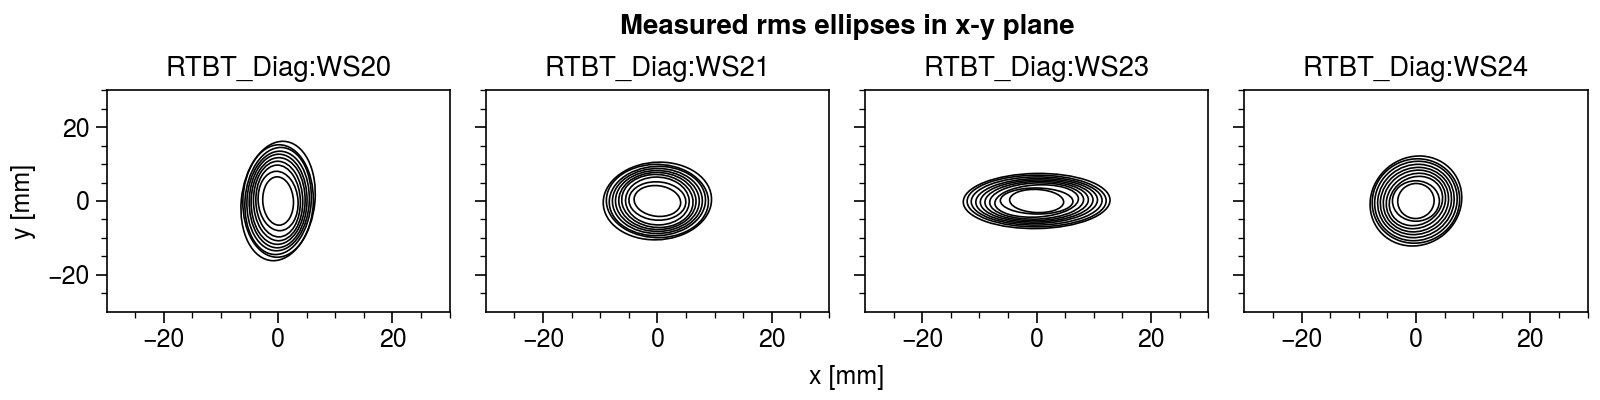

In [12]:
fig, axes = pplt.subplots(ncols=4, figsize=(8, 2))
for ax, ws_id in zip(axes, ws_ids):
    ax.set_title(ws_id)
    for sig_xx, sig_yy, sig_xy in moments_dict[ws_id]:
        angle = -0.5 * np.arctan2(2*sig_xy, sig_xx-sig_yy)
        sn, cs = np.sin(angle), np.cos(angle)
        c1 = np.sqrt(abs(sig_xx*cs**2 + sig_yy*sn**2 - 2*sig_xy*sn*cs))
        c2 = np.sqrt(abs(sig_xx*sn**2 + sig_yy*cs**2 + 2*sig_xy*sn*cs))
        myplt.ellipse(ax, c1, c2, angle)
axes.format(xlim=(-30, 30), ylim=(-30, 30), xlabel='x [mm]', ylabel='y [mm]',
            suptitle='Measured rms ellipses in x-y plane')
plt.savefig('_output/figures/corr.png', **savefig_kws)

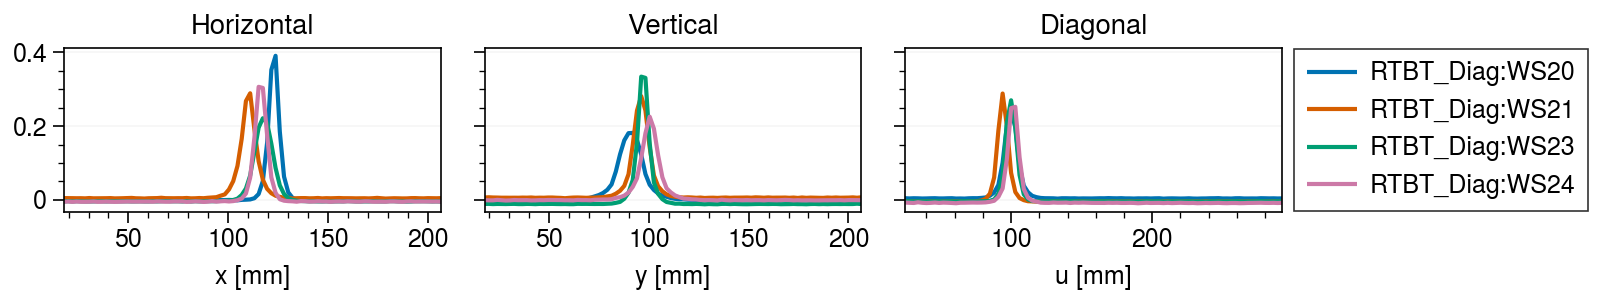

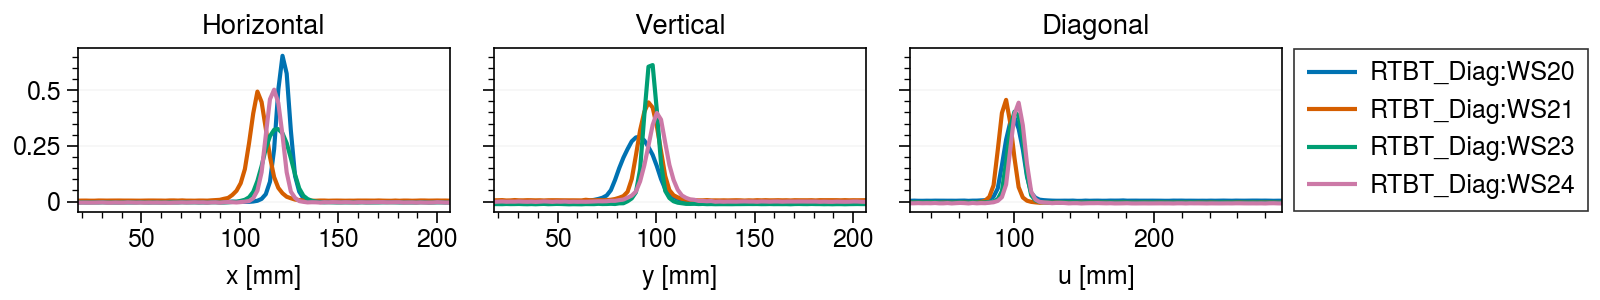

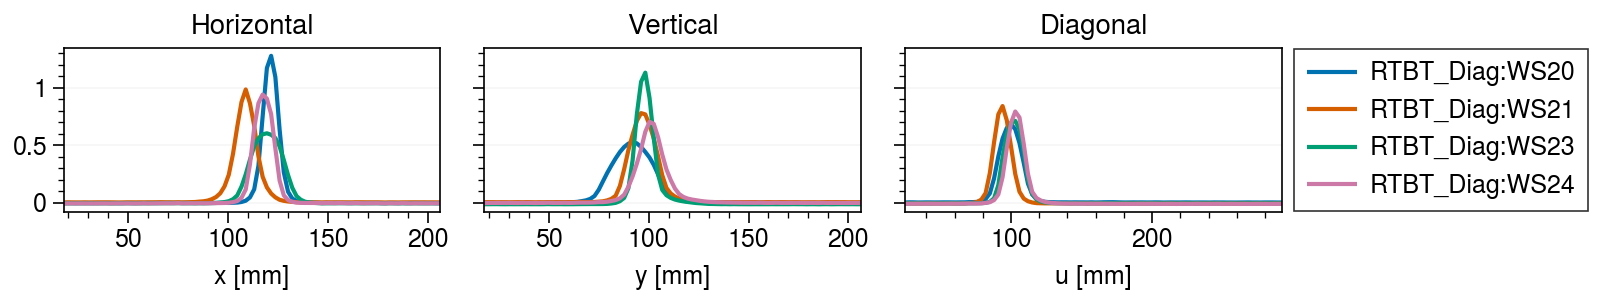

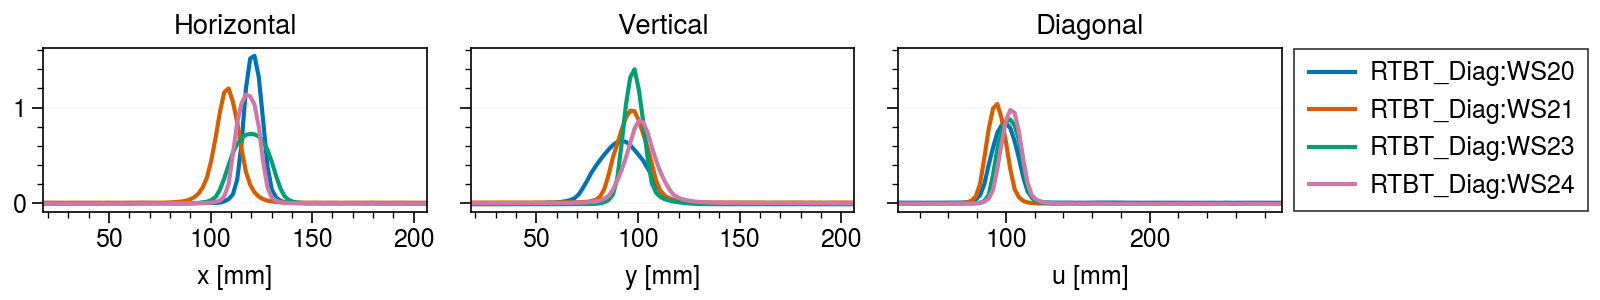

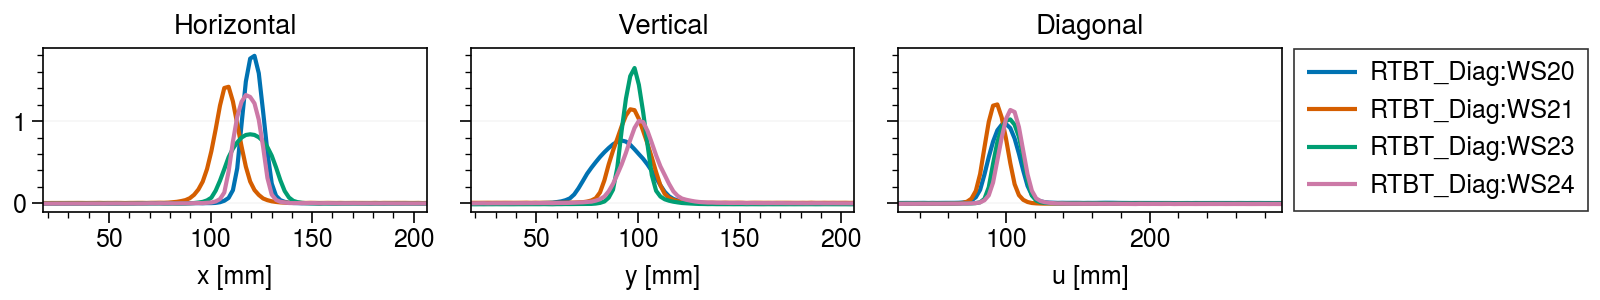

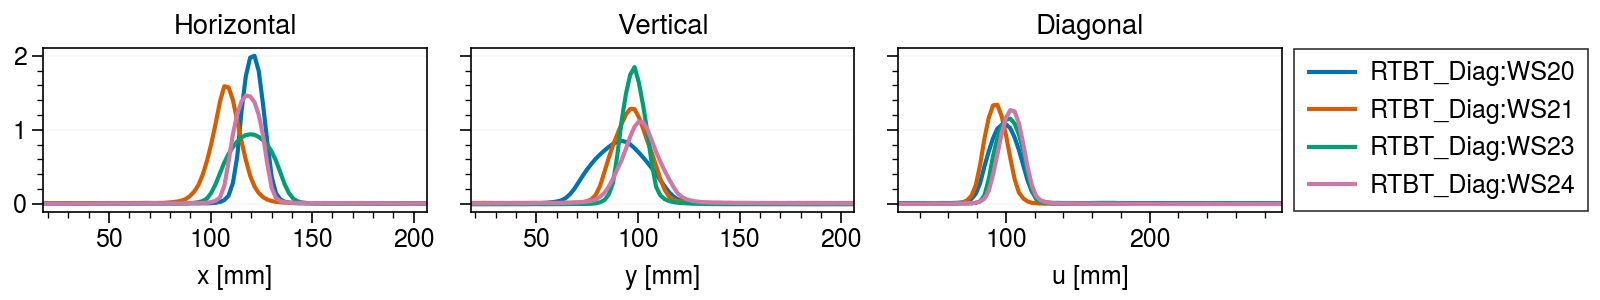

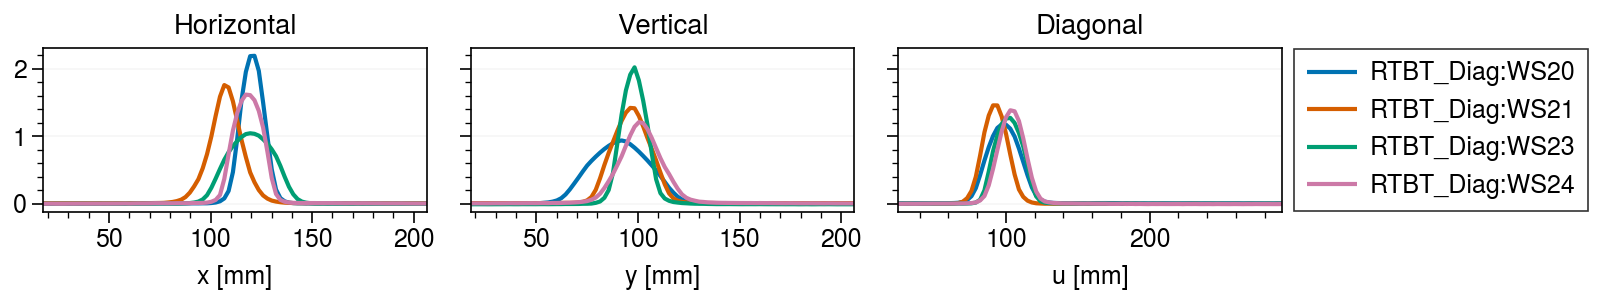

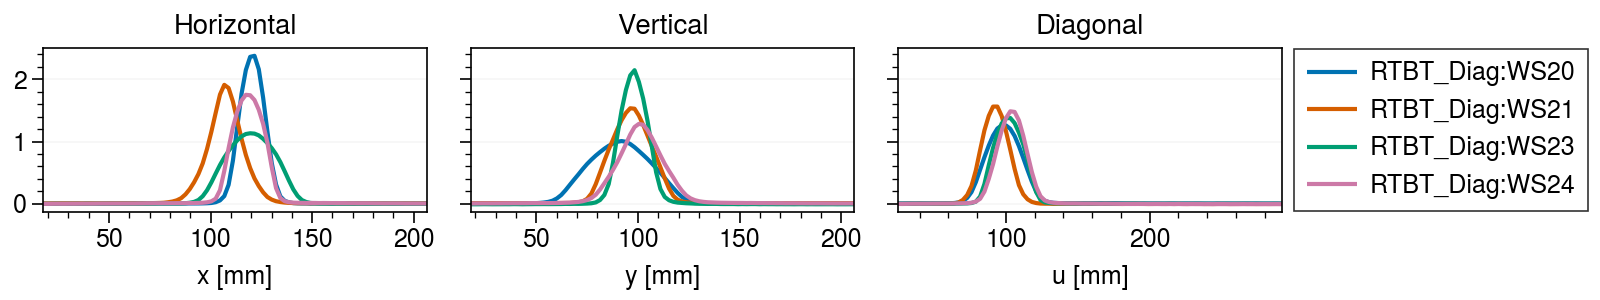

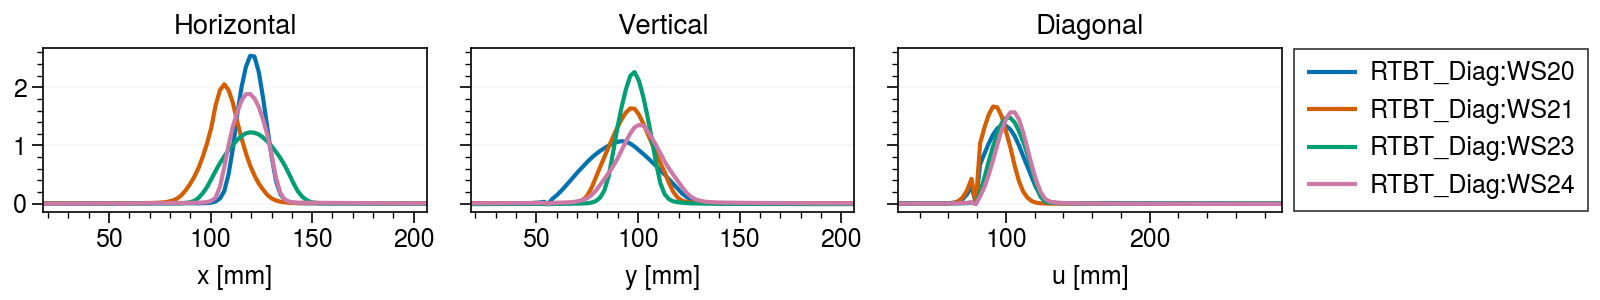

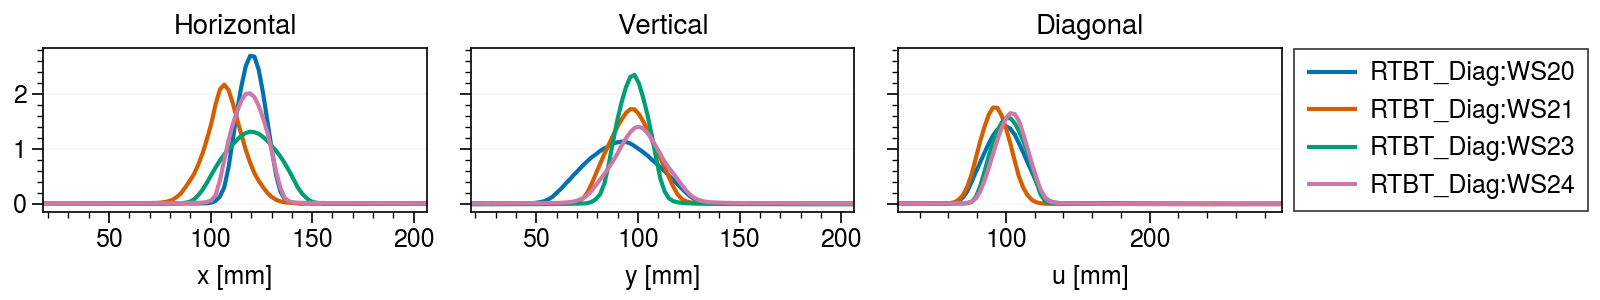

In [13]:
plt_kws = dict(marker='.', ms=0)

for meas_index in range(n_meas):
    fig, axes = pplt.subplots(ncols=3, figsize=(8, 1.5), sharex=False)
    handles = []
    for ws_id in ws_ids:
        axes[0].plot(pos_x_dict[ws_id][meas_index], raw_x_dict[ws_id][meas_index], **plt_kws)
        axes[1].plot(pos_y_dict[ws_id][meas_index], raw_y_dict[ws_id][meas_index], **plt_kws)
        g = axes[2].plot(pos_u_dict[ws_id][meas_index], raw_u_dict[ws_id][meas_index], **plt_kws)
        handles.append(g)
    axes[0].format(xlabel='x [mm]', title='Horizontal')
    axes[1].format(xlabel='y [mm]', title='Vertical')
    axes[2].format(xlabel='u [mm]', title='Diagonal')
    for ax in axes:
        ax.grid(axis='y')
    axes[2].legend(handles, labels=ws_ids, ncols=1, loc='r', fontsize=6.5)
    plt.savefig('_output/figures/profiles_{}'.format(meas_index), **savefig_kws)
    plt.show()

In [14]:
# emittances = []
# nkeep = list(range(1, n_meas))
# for j in nkeep:
#     tmats_list, moments_list = [], []
#     for ws_id in ws_ids:
#         tmats_list.extend(tmats_dict[ws_id][:j])
#         moments_list.extend(moments_dict[ws_id][:j])
#     Sigma = reconstruct(tmats_list, moments_list)
#     emittances.append(ba.emittances(Sigma))
# emittances = np.array(emittances)
    
# fig, ax = pplt.subplots()
# ax.plot(nkeep, np.sqrt(emittances[:, 0] * emittances[:, 1]) - np.sqrt(eps_x * eps_y), 
#         marker='.', color='red8')
# ax.plot(nkeep, np.sqrt(emittances[:, 2] * emittances[:, 3]) - np.sqrt(eps_1 * eps_2),
#         marker='.', color='blue8')
# ax.legend(labels=[r'$\sqrt{\varepsilon_x\varepsilon_y}$', r'$\sqrt{\varepsilon_1\varepsilon_2}$'], ncols=2)
# ax.format(xlabel='Number of measurements used', ylabel='Difference from full fit [mm mrad]')
# plt.savefig('_output/figures/nmeas.png', facecolor='white', dpi=300)

## Reconstruction

In [15]:
tmats_list, moments_list = [], []
for ws_id in ws_ids:
    tmats_list.extend(tmats_dict[ws_id])
    moments_list.extend(moments_dict[ws_id])

In [16]:
Sigma = reconstruct(tmats_list, moments_list, verbose=2)

The unconstrained solution is optimal.
Final cost 5.2048e+04, first-order optimality 5.85e-09


In [17]:
Corr = utils.cov2corr(Sigma)
alpha_x, alpha_y, beta_x, beta_y = ba.twiss2D(Sigma)
eps_x, eps_y, eps_1, eps_2 = ba.emittances(Sigma)
coupling_coeff = 1.0 - np.sqrt((eps_1 * eps_2) / (eps_x * eps_y))

print('Sigma =')
print(Sigma)
print('Corr =')
print(Corr)
print('eps_4D = {:.3f}'.format(np.sqrt(np.linalg.det(Sigma))))
print('eps_1, eps_2 = {:.3f}, {:.3f}'.format(eps_1, eps_2))
print('eps_x, eps_y = {:.3f}, {:.3f}'.format(eps_x, eps_y))
print('alpha_x, alpha_y = {:.3f}, {:.3f}'.format(alpha_x, alpha_y))
print('beta_x, beta_y = {:.3f}, {:.3f}'.format(beta_x, beta_y))
print('Coupling coefficient = {}'.format(coupling_coeff))

Sigma =
[[ 3.84152585e+02  1.27768008e+01 -6.60527091e+00  8.03214614e-01]
 [ 1.27768008e+01  4.78454507e-01 -1.57757748e-01  6.12208828e-03]
 [-6.60527091e+00 -1.57757748e-01  4.22130988e+01 -5.24256237e+00]
 [ 8.03214614e-01  6.12208828e-03 -5.24256237e+00  1.16725044e+00]]
Corr =
[[ 1.          0.94243177 -0.05186987  0.0379313 ]
 [ 0.94243177  1.         -0.0351032   0.00819214]
 [-0.05186987 -0.0351032   1.         -0.74685788]
 [ 0.0379313   0.00819214 -0.74685788  1.        ]]
eps_4D = 21.051
eps_1, eps_2 = 4.920, 4.279
eps_x, eps_y = 4.534, 4.668
alpha_x, alpha_y = -2.818, 1.123
beta_x, beta_y = 84.736, 9.043
Coupling coefficient = 0.00261035385240016


In [18]:
norm = '2D'
V = np.identity(4)
if norm == '2D':
    alpha_x, alpha_y, beta_x, beta_y = ba.twiss2D(Sigma)
    V = V_matrix_4x4_uncoupled(alpha_x, alpha_y, beta_x, beta_y)
elif norm == '4D':
    U = np.array([[0, 1, 0, 0], [-1, 0, 0, 0], [0, 0, 0, 1], [0, 0, -1, 0]])
    eigvals, eigvecs = np.linalg.eig(np.matmul(Sigma, U))
    V = BL.construct_V(eigvecs)
Vinv = np.linalg.inv(V)
Sigma_n = np.linalg.multi_dot([Vinv, Sigma, Vinv.T])

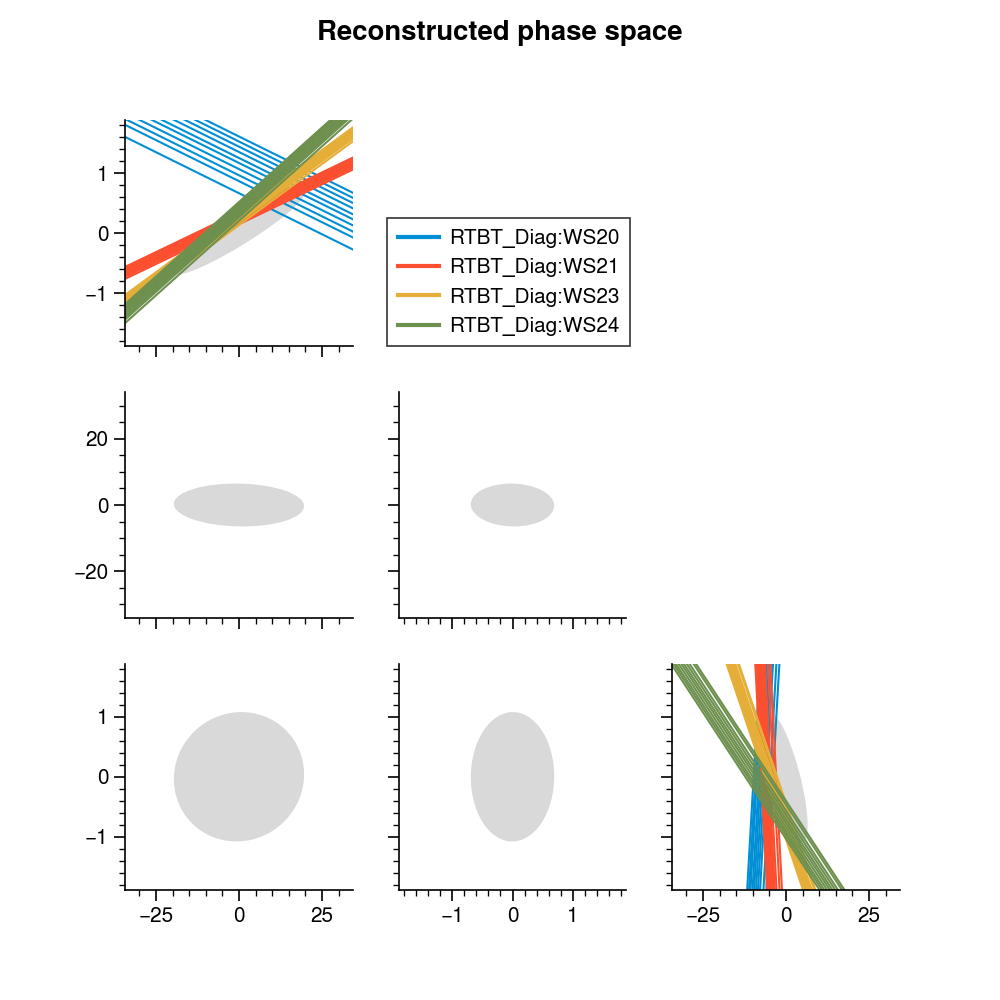

In [19]:
axes = myplt.rms_ellipses(Sigma, color='black', pad=0.75, alpha=0.15, fill=True, lw=0, zorder=0)
plt.suptitle('Reconstructed phase space')
reconstruction_lines(axes[2, 2], tmats_dict, moments_dict, plane='y-yp')
reconstruction_lines(axes[0, 0], tmats_dict, moments_dict, plane='x-xp',
                     legend=True, legend_kws=dict(loc=(1.15, 0)))
plt.savefig('_output/figures/corner.png', **savefig_kws)

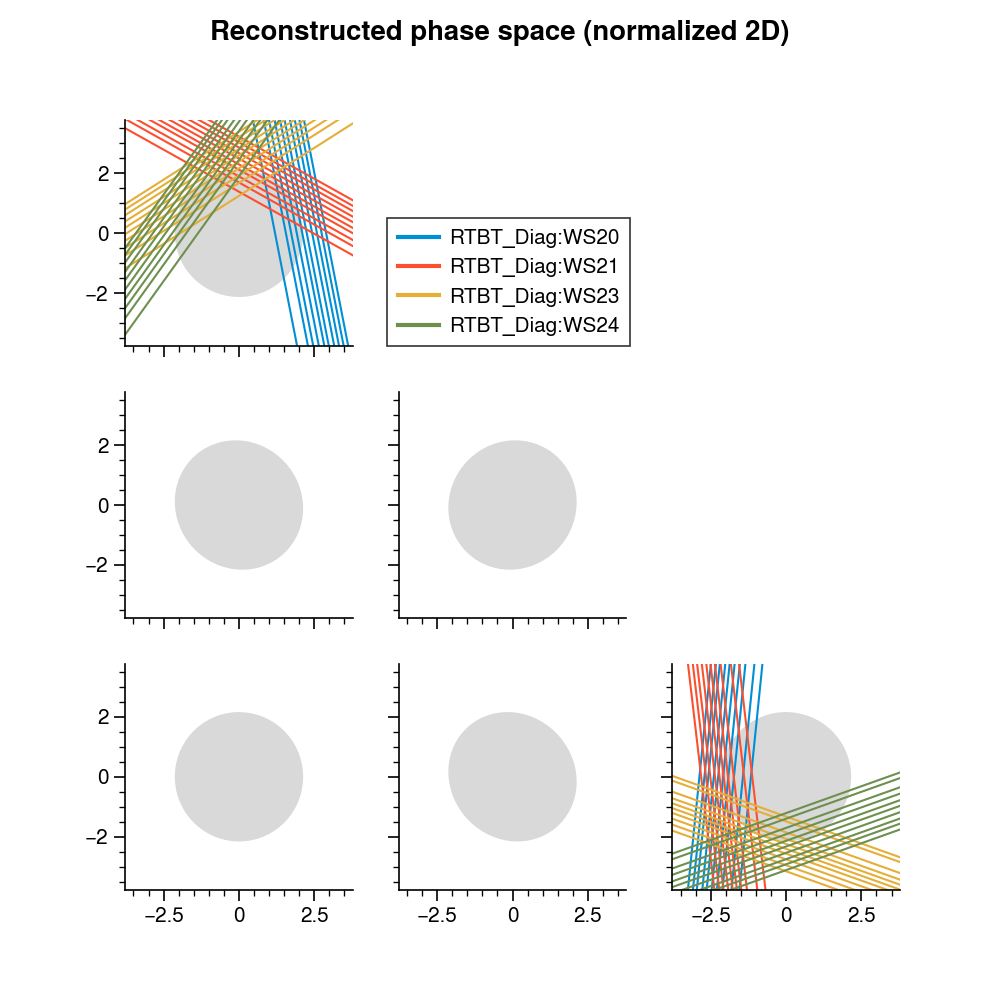

In [20]:
axes = myplt.rms_ellipses(Sigma_n, color='black', pad=0.75, alpha=0.15, fill=True, lw=0, zorder=0)
plt.suptitle('Reconstructed phase space (normalized {})'.format(norm))
reconstruction_lines(axes[2, 2], tmats_dict, moments_dict, plane='y-yp', norm_mat=V)
reconstruction_lines(axes[0, 0], tmats_dict, moments_dict, plane='x-xp', norm_mat=V,
                     legend=True, legend_kws=dict(loc=(1.15, 0)))
plt.savefig('_output/figures/corner_norm.png', **savefig_kws)

### Errors from LLSQ 

In [21]:
def propagate_emittance_errors(Sigma, C):
    """Compute standard deviation from computed Sigma and LLSQ covariance matrix C.
    
    To do: do the same for the Twiss parameters. It should be easy.
    """
    eps_x, eps_y, eps_1, eps_2 = ba.emittances(Sigma)
    
    Cxx = C[:3, :3]
    Cyy = C[3:6, 3:6]
    Cxy = C[6:, 6:]
    
    grad_eps_x = (0.5 / eps_x) * np.array([Sigma[1, 1], Sigma[0, 0], -2 * Sigma[0, 1]])
    grad_eps_y = (0.5 / eps_y) * np.array([Sigma[3, 3], Sigma[2, 2], -2 * Sigma[2, 3]])
    eps_x_std = np.sqrt(np.linalg.multi_dot([grad_eps_x.T, Cxx, grad_eps_x]))
    eps_y_std = np.sqrt(np.linalg.multi_dot([grad_eps_y.T, Cyy, grad_eps_y]))
    
    g1 = np.linalg.det(Sigma)
    U = np.array([[0, 1, 0, 0], [-1, 0, 0, 0], [0, 0, 0, 1], [0, 0, -1, 0]])
    SigmaU = np.matmul(Sigma, U)
    g2 = np.trace(np.matmul(SigmaU, SigmaU))
    g = np.array(g1, g2)
    
    s11, s12, s13, s14 = Sigma[0, :]
    s22, s23, s24 = Sigma[1, 1:]
    s33, s34 = Sigma[2, 2:]
    s44 = Sigma[3, 3]

    grad_g = np.zeros((10, 2))
    grad_g[0, 0] = -s33*s24**2 + 2*s23*s24*s34 - s44*s23**2 + s22*(s33*s44 - s34**2)
    grad_g[1, 0] = -s33*s14**2 + 2*s13*s14*s34 - s44*s13**2 + s11*(s33*s44 - s34**2)
    grad_g[2, 0] = 2 * (s14*(s24*s33 - s23*s34) + s13*(-s24*s34 + s23*s44) + s12*(s34**2 - s33*s44))
    grad_g[3, 0] = -s22*s14**2 + 2*s12*s14*s24 - s44*s12**2 + s11*(s22*s44 - s24**2)
    grad_g[4, 0] = -s22*s13**2 + 2*s12*s13*s23 - s33*s12**2 + s11*(s22*s33 - s23**2)
    grad_g[5, 0] = 2 * (-s12*s14*s23 + s13*(s14*s22 - s12*s24) + s34*s12**2 + s11*(s23*s24 - s22*s34))
    grad_g[6, 0] = 2 * (s14*(-s23*s24 + s22*s34) + s13*(s24**2 - s22*s44) + s12*(-s24*s34 + s23*s44))
    grad_g[7, 0] = 2 * (s23*s14**2 - s14*(s13*s24 + s12*s34) + s12*s13*s44 + s11*(s24*s34 - s23*s44))
    grad_g[8, 0] = 2 * (s14*(s23**2 - s22*s33) + s13*(-s23*s24 + s22*s34) + s12*(s24*s33 - s23*s34))
    grad_g[9, 0] = 2 * (s24*s13**2 + s12*s14*s33 - s13*(s14*s23 + s12*s34) + s11*(-s24*s33 + s23*s34))

    grad_g[0, 1] = -2 * s22
    grad_g[1, 1] = -2 * s11
    grad_g[2, 1] = 4 * s12
    grad_g[3, 1] = -2 * s44
    grad_g[4, 1] = -2 * s33
    grad_g[5, 1] = 4 * s34
    grad_g[6, 1] = -4 * s24
    grad_g[7, 1] = 4 * s24
    grad_g[8, 1] = 4 * s23
    grad_g[9, 1] = -4 * s13
    
    Cg = np.linalg.multi_dot([grad_g.T, C, grad_g])
    
    H = np.sqrt(g2**2 - 16 * g1)
    deps1_dg1 = -1 / (eps_1 * H)
    deps2_dg1 = -1 / (eps_2 * H)
    deps1_dg2 = (1/8) * (1/eps_1) * (+g2/H - 1)
    deps2_dg2 = (1/8) * (1/eps_2) * (-g2/H - 1)
    grad_eps_1 = np.array([deps1_dg1, deps1_dg2])
    grad_eps_2 = np.array([deps2_dg1, deps2_dg2])
    
    eps_1_std = np.linalg.multi_dot([grad_eps_1.T, Cg, grad_eps_1])
    eps_2_std = np.linalg.multi_dot([grad_eps_2.T, Cg, grad_eps_2])

    return np.array([eps_x_std, eps_y_std, eps_1_std, eps_2_std])

In [22]:
def llsq_cov_mat(A, res):
    n, p = np.shape(A)
    if n == p:
        C = np.linalg.inv(A)
    else:
        C = (res / (n - p)) * np.linalg.inv(np.matmul(A.T, A))
    return C

In [23]:
def reconstruct(tmats_list, moments_list):
    # Form coefficient arrays and target arrays, 
    Axx, Ayy, Axy, bxx, byy, bxy = [], [], [], [], [], []
    for M, (sig_xx, sig_yy, sig_xy) in zip(tmats_list, moments_list):
        Axx.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1]])
        Ayy.append([M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3]])
        Axy.append([M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
        bxx.append(sig_xx)
        byy.append(sig_yy)
        bxy.append(sig_xy)
    Axx = np.array(Axx)
    Ayy = np.array(Ayy)
    Axy = np.array(Axy)

    # Solve LLSQ problem.
    vec_xx, res_xx, _, _ = np.linalg.lstsq(Axx, bxx, rcond=None)
    vec_yy, res_yy, _, _ = np.linalg.lstsq(Ayy, byy, rcond=None)
    vec_xy, res_xy, _, _ = np.linalg.lstsq(Axy, bxy, rcond=None)
    if len(res_xy) == 0:
        res_xy = 0.0

#     # Use bounded solver for sig_xy since there are exactly four measurements.
#     def inverse_cholesky(x):
#         L = np.array([[x[0], 0, 0, 0],
#                       [x[1], x[2], 0, 0],
#                       [x[3], x[4], x[5], 0],
#                       [x[6], x[7], x[8], x[9]]])
#         return np.matmul(L, L.T)

#     def cost_func(x):
#         S = inverse_cholesky(x)
#         vec_xx = np.array([S[0, 0], S[1, 1], S[0, 1]])
#         vec_yy = np.array([S[2, 2], S[3, 3], S[2, 3]])
#         vec_xy = np.array([S[0, 2], S[1, 2], S[0, 3], S[1, 3]])
#         cost = 0.
#         cost += np.sum((np.matmul(Axx, vec_xx) - bxx)**2)
#         cost += np.sum((np.matmul(Ayy, vec_yy) - byy)**2)
#         cost += np.sum((np.matmul(Axy, vec_xy) - bxy)**2)
#         return cost

#     lb = -np.inf
#     ub = +np.inf
#     guess = np.random.uniform(-10, 10, size=10)
#     result = opt.minimize(cost_func, guess, bounds=opt.Bounds(lb, ub))
#     S = inverse_cholesky(result.x)

    
#     vec_xx = np.array([S[0, 0], S[1, 1], S[0, 1]])
#     vec_yy = np.array([S[2, 2], S[3, 3], S[2, 3]])
#     vec_xy = np.array([S[0, 2], S[1, 2], S[0, 3], S[1, 3]])
#     res_xx = np.sum((np.matmul(Axx, vec_xx) - bxx)**2)
#     res_yy = np.sum((np.matmul(Ayy, vec_yy) - byy)**2)
#     res_xy = np.sum((np.matmul(Axy, vec_xy) - bxy)**2)


    res_xx = float(res_xx)
    res_yy = float(res_yy)
    res_xy = float(res_xy)
    
    # Compute standard deviation of parameter vectors.
    Cxx = llsq_cov_mat(Axx, res_xx)
    Cyy = llsq_cov_mat(Ayy, res_yy)
    Cxy = llsq_cov_mat(Axy, res_xy)
    
    sig_11, sig_22, sig_12 = vec_xx
    sig_33, sig_44, sig_34 = vec_yy
    sig_13, sig_23, sig_14, sig_24 = vec_xy
    Sigma = np.array([[sig_11, sig_12, sig_13, sig_14],
                      [sig_12, sig_22, sig_23, sig_24],
                      [sig_13, sig_23, sig_33, sig_34],
                      [sig_14, sig_24, sig_34, sig_44]])
    C = np.zeros((10, 10))
    C[:3, :3] = Cxx
    C[3:6, 3:6] = Cyy
    C[6:, 6:] = Cxy
    
    return Sigma, C

In [24]:
Sigma, C = reconstruct(tmats_list, moments_list)
eps_x, eps_y, eps_1, eps_2 = ba.emittances(Sigma)
eps_x_std, eps_y_std, eps_1_std, eps_2_std = propagate_emittance_errors(Sigma, C)

print('eps_x = {} +\- {} [mm mrad]'.format(eps_x, eps_x_std))
print('eps_y = {} +\- {} [mm mrad]'.format(eps_y, eps_y_std))
print('eps_1 = {} +\- {} [mm mrad]'.format(eps_1, eps_1_std))
print('eps_2 = {} +\- {} [mm mrad]'.format(eps_2, eps_2_std))

eps_x = 4.533530290541196 +\- 0.5307735240654113 [mm mrad]
eps_y = 4.6678472364521335 +\- 0.6795064129253677 [mm mrad]
eps_1 = 4.920029958919619 +\- 0.34251766948170426 [mm mrad]
eps_2 = 4.278732344517633 +\- 38.075718593241255 [mm mrad]


### Reconstruct at each step

In [30]:
Sigmas = []
Cmats = []
for meas_index in range(n_meas):
    tmats_list, moments_list = [], []
    for ws_id in ws_ids:
        tmats_list.append(tmats_dict[ws_id][meas_index])
        moments_list.append(moments_dict[ws_id][meas_index])
    Sigma, C = reconstruct(tmats_list, moments_list)
    Sigmas.append(Sigma)
    Cmats.append(C)

In [26]:
stats = ba.StatsReader()
stats.read_moments(np.array([Sigma[np.triu_indices(4)] for Sigma in Sigmas]))

In [27]:
stds = np.array([propagate_emittance_errors(Sigma, C) for Sigma, C in zip(Sigmas, Cmats)])

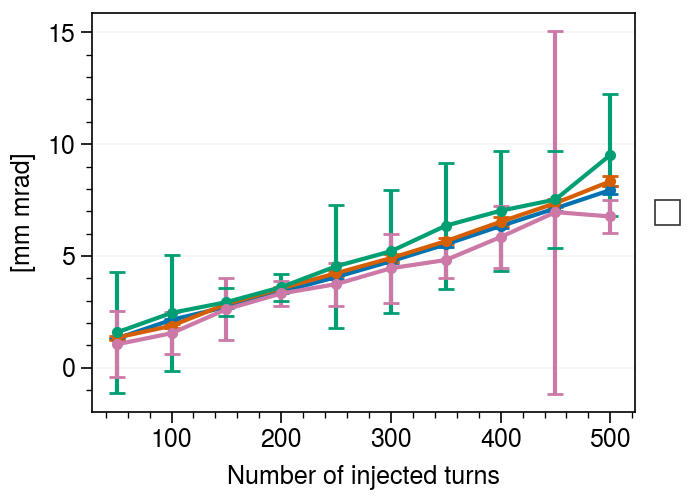

In [28]:
fig, ax = pplt.subplots(figsize=(3.5, 2.5))
plt_kws = dict(marker='.')
n_turns = list(range(50, 550, 50))
g1 = ax.errorbar(n_turns, stats.twiss2D['eps_x'], yerr=stds[:, 0], **plt_kws)
g2 = ax.errorbar(n_turns, stats.twiss2D['eps_y'], yerr=stds[:, 1], **plt_kws)
g3 = ax.errorbar(n_turns, stats.twiss4D['eps_1'], yerr=stds[:, 2], **plt_kws)
g4 = ax.errorbar(n_turns, stats.twiss4D['eps_2'], yerr=stds[:, 3], **plt_kws)
ax.legend(handles=[g1, g2, g3, g4], labels=eps_labels, loc='r', ncols=1)
ax.format(xlabel='Number of injected turns', ylabel='[mm mrad]')
ax.grid(axis='y')
plt.savefig('_output/figures/emittances.png', **savefig_kws)

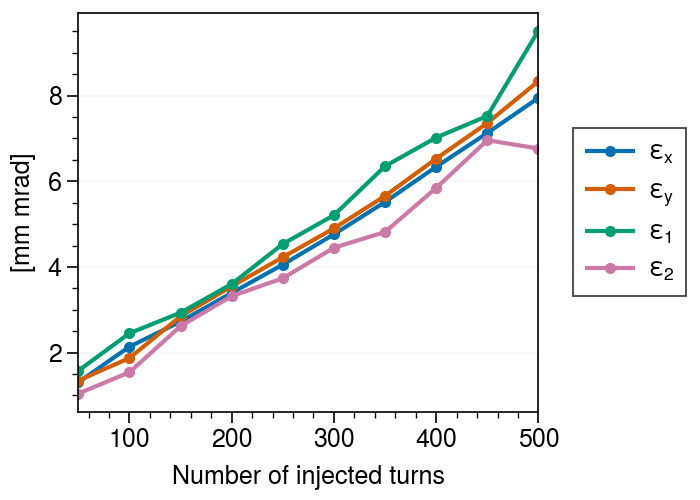

In [29]:
fig, ax = pplt.subplots(figsize=(3.5, 2.5))
plt_kws = dict(marker='.')
n_turns = list(range(50, 550, 50))
g1 = ax.plot(n_turns, stats.twiss2D['eps_x'], **plt_kws)
g2 = ax.plot(n_turns, stats.twiss2D['eps_y'], **plt_kws)
g3 = ax.plot(n_turns, stats.twiss4D['eps_1'], **plt_kws)
g4 = ax.plot(n_turns, stats.twiss4D['eps_2'], **plt_kws)
ax.legend(handles=[g1, g2, g3, g4], labels=eps_labels, loc='r', ncols=1)
ax.format(xlabel='Number of injected turns', ylabel='[mm mrad]')
ax.grid(axis='y')
plt.savefig('_output/figures/emittances.png', **savefig_kws)

In [ ]:
fig, ax = pplt.subplots(figsize=(3.5, 2.5))
g1 = ax.plot(n_turns, stats.twiss2D['eps_x'] * stats.twiss2D['eps_y'], color='red', **plt_kws)
g2 = ax.plot(n_turns, stats.twiss4D['eps_1'] * stats.twiss4D['eps_2'], color='blue', **plt_kws)
ax.legend(handles=[g1, g2], labels=[''.join(eps_labels[:2]), ''.join(eps_labels[2:])], loc='r', ncols=1)
ax.format(xlabel='Number of injected turns', ylabel=r'[mm$^2$ mrad$^2$]')
ax.grid(axis='y')
plt.savefig('_output/figures/emittances4D.png', **savefig_kws)

In [ ]:
fig, axes = pplt.subplots(nrows=2, figsize=(3.5, 3.5), spany=False, aligny=True)
g1 = axes[0].plot(n_turns, stats.twiss2D['eps_x'], **plt_kws)
g2 = axes[0].plot(n_turns, stats.twiss2D['eps_y'], **plt_kws)
g3 = axes[0].plot(n_turns, stats.twiss4D['eps_1'], **plt_kws)
g4 = axes[0].plot(n_turns, stats.twiss4D['eps_2'], **plt_kws)
axes[0].legend(handles=[g1, g2, g3, g4], labels=eps_labels, loc='r', ncols=1)

g1 = axes[1].plot(n_turns, stats.twiss2D['eps_x'] * stats.twiss2D['eps_y'], color='red', **plt_kws)
g2 = axes[1].plot(n_turns, stats.twiss4D['eps_1'] * stats.twiss4D['eps_2'], color='blue', **plt_kws)
axes[1].legend(handles=[g1, g2], labels=[''.join(eps_labels[:2]), ''.join(eps_labels[2:])], 
               loc='r', ncols=1)

axes[0].format(ylabel='[mm mrad]', xlabel='Turn number')
axes[1].format(ylabel=r'[mm$^2$ mrad$^2$]')
for ax in axes:
    ax.grid(axis='y')
plt.savefig('_output/figures/emittances_combined.png', facecolor='w', dpi=300)

In [ ]:
eps_x = stats.twiss2D['eps_x']
eps_y = stats.twiss2D['eps_y']
eps_1 = stats.twiss4D['eps_1']
eps_2 = stats.twiss4D['eps_2']
C = 1.0 - (eps_1 * eps_2) / (eps_x * eps_y)

fig, ax = pplt.subplots(figsize=(2.5, 2.5))
ax.plot(n_turns, C, marker='.', color='k')
ax.grid(axis='y')
ax.format(xlabel='Turn number', 
          title=r'C = 1 - $\frac{\varepsilon_1\varepsilon_2}{\varepsilon_x\varepsilon_y}$',
          ylim=(0, 1))
plt.savefig('_output/figures/C.png', **savefig_kws)

In [ ]:
for meas_index in meas_indices:

    Sigma = Sigmas[meas_index]
    axes = myplt.rms_ellipses(Sigma, color='black', pad=0.75, alpha=0.15, fill=True, lw=0, zorder=0)
    plt.suptitle('Reconstructed phase space - turn {}'.format(n_turns[meas_index]), fontsize='medium')

    _tmats_dict = dict()
    _moments_dict = dict()
    for ws_id in ws_ids:
        _tmats_dict[ws_id] = tmats_dict[ws_id][meas_index:meas_index + 1]
        _moments_dict[ws_id] = moments_dict[ws_id][meas_index:meas_index + 1]
    reconstruction_lines(axes[2, 2], _tmats_dict, _moments_dict, plane='y-yp')
    reconstruction_lines(axes[0, 0], _tmats_dict, _moments_dict, plane='x-xp',
                         legend=True, legend_kws=dict(loc=(1.15, 0)))
    plt.savefig('_output/figures/corner_ninjturns={}.png'.format(n_turns[meas_index]), **savefig_kws)
    plt.show()

In [ ]:
cmap = pplt.Colormap('flare')

axes = myplt.rms_ellipses(Sigmas, 
                          cmap=cmap
                         )
plt.savefig('_output/figures/corner_all.png', **savefig_kws)

## Errors

### Propagate errors from linear least squares 

In [ ]:
# emittances = []
# nkeep = list(range(1, n_meas))
# for j in nkeep:
#     tmats_list, moments_list = [], []
#     for ws_id in ws_ids:
#         tmats_list.extend(tmats_dict[ws_id][:j])
#         moments_list.extend(moments_dict[ws_id][:j])
#     Sigma = reconstruct(tmats_list, moments_list)
#     emittances.append(ba.emittances(Sigma))
# emittances = np.array(emittances)
    
# fig, ax = pplt.subplots()
# ax.plot(nkeep, np.sqrt(emittances[:, 0] * emittances[:, 1]) - np.sqrt(eps_x * eps_y), 
#         marker='.', color='red8')
# ax.plot(nkeep, np.sqrt(emittances[:, 2] * emittances[:, 3]) - np.sqrt(eps_1 * eps_2),
#         marker='.', color='blue8')
# ax.legend(labels=[r'$\sqrt{\varepsilon_x\varepsilon_y}$', r'$\sqrt{\varepsilon_1\varepsilon_2}$'], ncols=2)
# ax.format(xlabel='Number of measurements used', ylabel='Difference from full fit [mm mrad]')
# plt.savefig('_output/figures/nmeas.png', facecolor='white', dpi=300)

### 

In [ ]:
Sigma_all_meas = np.copy(Sigma)
emittances_all_meas = ba.emittances(Sigma_all_meas)
eps_x_all_meas, eps_y_all_meas, eps_1_all_meas, eps_2_all_meas = emittances_all_meas

In [ ]:
def plot_with_error_bars(data, labels, correct=None):
    data = np.array(data)
    means, stds = np.mean(data, axis=0), np.std(data, axis=0)
    n_rows, n_cols = data.shape
    
    plt_kws = dict(marker='.', lw=0)
    if data.ndim == 1:
        colors = ['black']
    else:
        colors = copy.copy(myplt.DEFAULT_COLORCYCLE)
        colors[2], colors[3] = colors[3], colors[2]

    fig, ax = pplt.subplots(figsize=None)
    for i in range(n_cols):
        ax.errorbar(range(n_rows), data[:, i], yerr=stds[i], capsize=3, elinewidth=1, color=colors[i], **plt_kws)
        if correct:
            ax.axhline(correct[i], color=colors[i], alpha=0.2)
    ax.format(xlabel='Measurement index', ylabel='[mm mrad]', xtickminor=False, xticks=range(len(emittances)))

    ax.legend([Line2D([0], [0], c=c, **plt_kws) for c in colors[:4]], labels, ncol=1, loc='r')
    line = []
    for i in range(4):
        line.append(r'{} = {:.3f} $\pm$ {:.3f} [mm mrad]'.format(labels[i], means[i], stds[i]))
        line.append('\n')
    ax.set_title(''.join(line[:-1]))
    return ax

In [ ]:
def form_coeff_target_arrays(meas_index):
    Axx, Ayy, Axy = [], [], []
    bxx, byy, bxy = [], [], []
    for ws_id in ws_ids:
        M = tmats_dict[ws_id][meas_index]
        sig_xx, sig_yy, sig_xy = moments_dict[ws_id][meas_index]
        Axx.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1]])
        Ayy.append([M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3]])
        Axy.append([M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
        bxx.append(sig_xx)
        byy.append(sig_yy)
        bxy.append(sig_xy) 
    Axx, Ayy, Axy = np.array(Axx), np.array(Ayy), np.array(Axy)
    bxx, byy, bxy = np.array(bxx), np.array(byy), np.array(bxy)
    return Axx, Ayy, Axy, bxx, byy, bxy

### Bounds on cross-plane moments

In [ ]:
def solve_corr_coeff_bounds(meas_index, **solver_kws):
    Axx, Ayy, Axy, bxx, byy, bxy = form_coeff_target_arrays(meas_index)
    sig_11, sig_22, sig_12 = opt.lsq_linear(Axx, bxx).x
    sig_33, sig_44, sig_34 = opt.lsq_linear(Ayy, byy).x  

    def cost_func(vec):
        return np.sum((np.matmul(Axy, vec) - bxy)**2)

    r_13_denom = np.sqrt(sig_11 * sig_33)
    r_23_denom = np.sqrt(sig_22 * sig_33)
    r_14_denom = np.sqrt(sig_11 * sig_44)
    r_24_denom = np.sqrt(sig_22 * sig_44)
    lb = [-r_13_denom, -r_23_denom, -r_14_denom, -r_24_denom]
    ub = [+r_13_denom, +r_23_denom, +r_14_denom, +r_24_denom]
    guess = 0.75 * np.array([lb[0], 0., 0., lb[3]])
    result = opt.least_squares(cost_func, guess, bounds=(lb, ub), **solver_kws)
    
    sig_13, sig_23, sig_14, sig_24 = result.x
    S = to_mat([sig_11, sig_22, sig_12, sig_33, sig_44, sig_34, sig_13, sig_23, sig_14, sig_24])
    return ba.emittances(S)

In [ ]:
# solver_kws = dict(max_nfev=1000)
# emittances = [solve_corr_coeff_bounds(meas_index, **solver_kws) for meas_index in trange(n_meas)]    
# plot_with_error_bars(emittances, eps_labels, correct=emittances_all_meas);

### Edwards-Teng

We can parameterize the covariance matrix as 

$$
\mathbf{\Sigma} = \mathbf{V} \, \mathbf{C} \, \mathbf{\Sigma}_n \, \mathbf{C}^T \, \mathbf{V}^T,
$$

with

$$
\mathbf{\Sigma}_n = 
\begin{bmatrix}
    \varepsilon_1 & 0 & 0 & 0 \\
    0 & \varepsilon_1 & 0 & 0 \\
    0 & 0 & \varepsilon_2 & 0 \\
    0 & 0 & 0 & \varepsilon_2
\end{bmatrix}, \\
$$

$$
\mathbf{C} = 
\begin{bmatrix}
    1 & 0 & a & b \\
    0 & 1 & c & d \\
    -d & b & 1 & 0 \\
    c & a & 0 & 1
\end{bmatrix}, \\
$$

$$
\mathbf{V} = 
\begin{bmatrix}
    \sqrt{\beta_x} & 0 & 0 & 0 \\
    -\frac{\alpha_x}{\sqrt{\beta_x}} & \frac{1}{\sqrt{\beta_x}} & 0 & 0 \\
    0 & 0 & \sqrt{\beta_y} & 0 \\
    0 & 0 & -\frac{\alpha_y}{\sqrt{\beta_y}} & \frac{1}{\sqrt{\beta_y}}
\end{bmatrix}. \\
$$

$\mathbf{C}$ is symplectic if $ad - bc = 0$, so we set $d = bc/a$. If $a = b = c = d = 0$, then we get the normal uncoupled matrix with $\varepsilon_{x,y} = \varepsilon_{1,2}$. 

The strategy is to fit the $x$-$x'$ and $y$-$y'$ planes first, then choose $\varepsilon_1$, $\varepsilon_2$, $a$, $b$, and $c$.

In [ ]:
def get_cov(eps_1, eps_2, alpha_x, alpha_y, beta_x, beta_y, a, b, c):
    E = np.diag([eps_1, eps_1, eps_2, eps_2])
    V = V_matrix_4x4_uncoupled(alpha_x, alpha_y, beta_x, beta_y)
    if a == 0:
        if b == 0 or c == 0:
            d = 0
        else:
            raise ValueError("a is zero but b * c is not zero.")
    else:
        d = b * c / a
    C = np.array([[1, 0, a, b], [0, 1, c, d], [-d, b, 1, 0], [c, -a, 0, 1]])
    return np.linalg.multi_dot([V, C, E, C.T, V.T])

In [ ]:
def solve_edwards_teng(meas_index, **solver_kws):
    Axx, Ayy, Axy, bxx, byy, bxy = form_coeff_target_arrays(meas_index)
    sig_11, sig_22, sig_12 = opt.lsq_linear(Axx, bxx).x
    sig_33, sig_44, sig_34 = opt.lsq_linear(Ayy, byy).x 
    S = np.zeros((4, 4))
    S[:2, :2] = [[sig_11, sig_12], [sig_12, sig_22]]
    S[2:, 2:] = [[sig_33, sig_34], [sig_34, sig_44]]
    eps_x, eps_y = ba.apparent_emittances(S)
    alpha_x, alpha_y, beta_x, beta_y = ba.twiss2D(S)

    def cost_func(vec):
        eps_1, eps_2, a, b, c = vec
        S = get_cov(eps_1, eps_2, alpha_x, alpha_y, beta_x, beta_y, a, b, c)
        vec_xy = np.array([S[0, 2], S[1, 2], S[0, 3], S[1, 3]])
        cost = np.sum((np.matmul(Axy, vec_xy) - bxy)**2)
        f = 1.0
        cost += f * (S[0, 0] - sig_11)**2
        cost += f * (S[0, 1] - sig_12)**2
        cost += f * (S[1, 1] - sig_22)**2
        cost += f * (S[2, 2] - sig_33)**2
        cost += f * (S[2, 3] - sig_34)**2
        cost += f * (S[3, 3] - sig_44)**2
        return cost

    lb = [0., 0., -np.inf, -np.inf, -np.inf]
    ub = np.inf
    guess = [0.75 * eps_x, 0.75 * eps_y, 0.5, 0.5, -0.5]
    result = opt.minimize(cost_func, guess, bounds=opt.Bounds(lb, ub), **solver_kws)
    eps_1, eps_2, a, b, c = result.x
    S = get_cov(eps_1, eps_2, alpha_x, alpha_y, beta_x, beta_y, a, b, c)
    S[:2, :2] = [[sig_11, sig_12], [sig_12, sig_22]]
    S[2:, 2:] = [[sig_33, sig_34], [sig_34, sig_44]]
    return ba.emittances(S)

In [ ]:
# solver_kws = dict(method='trust-constr', options=dict(verbose=0, xtol=1e-15, maxiter=1000))
# emittances = [solve_edwards_teng(meas_index, **solver_kws) for meas_index in trange(n_meas)]
# plot_with_error_bars(emittances, eps_labels, correct=emittances_all_meas);

### Cholesky decomposition 

In [ ]:
def inverse_cholesky(x):
    L = np.array([[x[0], 0, 0, 0],
                  [x[1], x[2], 0, 0],
                  [x[3], x[4], x[5], 0],
                  [x[6], x[7], x[8], x[9]]])
    return np.matmul(L, L.T)

In [ ]:
def solve_cholesky(meas_index, **solver_kws):
    Axx, Ayy, Axy, bxx, byy, bxy = form_coeff_target_arrays(meas_index)
    sig_11, sig_22, sig_12 = opt.lsq_linear(Axx, bxx).x
    sig_33, sig_44, sig_34 = opt.lsq_linear(Ayy, byy).x  

    def cost_func(x):
        S = inverse_cholesky(x)
        vec_xx = np.array([S[0, 0], S[1, 1], S[0, 1]])
        vec_yy = np.array([S[2, 2], S[3, 3], S[2, 3]])
        vec_xy = np.array([S[0, 2], S[1, 2], S[0, 3], S[1, 3]])
        cost = 0.
        cost += np.sum((np.matmul(Axx, vec_xx) - bxx)**2)
        cost += np.sum((np.matmul(Ayy, vec_yy) - byy)**2)
        cost += np.sum((np.matmul(Axy, vec_xy) - bxy)**2)
        return cost

    lb = -np.inf
    ub = +np.inf
    guess = np.ones(10)
#     guess = np.random.uniform(-10, 10, size=10)
    result = opt.minimize(cost_func, guess, bounds=opt.Bounds(lb, ub), **solver_kws)
    S = inverse_cholesky(result.x)
    return ba.emittances(S)

In [ ]:
# solver_kws = dict(method='trust-constr', options=dict(verbose=1, maxiter=2000))
# emittances = [solve_cholesky(meas_index, **solver_kws) for meas_index in trange(n_meas)]
# plot_with_error_bars(emittances, eps_labels, correct=emittances_all_meas);

### Simple simulation

Let's simulate the measurement very simply. We can start with the "correct" $\Sigma$ at the reconstruction point (the one we reconstructed using all the measurements). We'll transport this to each wire-scanner using the transfer matrices. We can add some error to the measured moments and try the reconstruction method. 

In [ ]:
def scatter_hist(x, y, ax, ax_marg_x, ax_marg_y, joint_kws=None, marginal_kws=None):
    if joint_kws is None:
        joint_kws = dict()
    if marginal_kws is None:
        marginal_kws = dict()        
    if 'range' in joint_kws:
        xrange, yrange = joint_kws['range']
    else:
        xrange = yrange = None
    if 'bins' in joint_kws:
        bins = joint_kws['bins']
    else:
        heights, edges, patches = ax_marg_x.hist(x, bins='auto', range=xrange, **marginal_kws)
        for patch in patches:
            patch.set_visible(False)
        bins = len(heights)
        joint_kws['bins'] = bins
    ax_marg_x.hist(x, range=xrange, bins=bins, **marginal_kws)
    ax_marg_y.hist(y, range=yrange, bins=bins, orientation='horizontal', **marginal_kws)
    ax.hist2d(x, y, **joint_kws)
    return ax

def create_grid(fig, gridspec, row, col):
    ax_joint = fig.add_subplot(gridspec[row, col])
    ax_marg_x = fig.add_subplot(gridspec[row - 1, col])
    ax_marg_y = fig.add_subplot(gridspec[row, col + 1])
    for ax in [ax_marg_x, ax_marg_y]:
        ax.set_xticks([])
        ax.set_yticks([])
        for side in ['top', 'bottom', 'left', 'right']:
            ax.spines[side].set_visible(False)
    return ax_joint, ax_marg_x, ax_marg_y

def emittances_joint_hist(emittances, lims=((10, 40), (0, 20))):
    fig = plt.figure(figsize=(10, 4))
    h = 1.5
    gridspec = fig.add_gridspec(2, 5, width_ratios=(7, h, 2.5, 7, h), height_ratios=(h, 7),
                                left=0.1, right=0.9, bottom=0.1, top=0.9,
                                wspace=0, hspace=0)
    ax1, ax1_marg_x, ax1_marg_y = create_grid(fig, gridspec, 1, 0)
    ax2, ax2_marg_x, ax2_marg_y = create_grid(fig, gridspec, 1, 3)

    joint_kws = dict(cmap='fire_r', range=lims, bins=75)
    marginal_kws = dict(histtype='step', color='black')

    scatter_hist(emittances[:, 0], emittances[:, 1], ax1, ax1_marg_x, ax1_marg_y, joint_kws, marginal_kws)
    scatter_hist(emittances[:, 2], emittances[:, 3], ax2, ax2_marg_x, ax2_marg_y, joint_kws, marginal_kws)
    ax1_marg_x.set_xlim(lims[0])
    ax1_marg_y.set_ylim(lims[1])
    ax2_marg_x.set_xlim(lims[0])
    ax2_marg_y.set_ylim(lims[1])
    ax1.set_xlabel(r'$\varepsilon_x$ [mm mrad]')
    ax1.set_ylabel(r'$\varepsilon_y$ [mm mrad]')
    ax2.set_xlabel(r'$\varepsilon_1$ [mm mrad]')
    ax2.set_ylabel(r'$\varepsilon_2$ [mm mrad]')
    ax1_marg_x.set_title(r'Apparent emittances ($\varepsilon_x$, $\varepsilon_y$)')
    ax2_marg_x.set_title(r'Intrinsic emittances ($\varepsilon_1$, $\varepsilon_2$)')      
    return ax1, ax1_marg_x, ax1_marg_y, ax2, ax1_marg_y, ax1_marg_y

In [ ]:
def get_moments(Sigma0, tmats, f=None):
    """Return [<xx>, <yy>, <xy>] at each wire-scanner.
    
    `f` is the rms fractional error added to the virtually measured moments. 
    """
    moments = []
    for M in tmats:            
        Sigma = np.linalg.multi_dot([M, Sigma0, M.T])
        sig_xx = Sigma[0, 0]
        sig_yy = Sigma[2, 2]
        sig_xy = Sigma[0, 2]
        sig_uu = 0.5 * (2 * sig_xy + sig_xx + sig_yy)
        if f:
            sig_xx *= (1.0 + np.random.normal(scale=f))**2
            sig_yy *= (1.0 + np.random.normal(scale=f))**2
            sig_uu *= (1.0 + np.random.normal(scale=f))**2
        sig_xy = 0.5 * (2 * sig_uu - sig_xx - sig_yy)
        moments.append([sig_xx, sig_yy, sig_xy])
    return moments

In [ ]:
def solve(tmats, moments, method='llsq'):
    Axx, Ayy, Axy = [], [], []
    bxx, byy, bxy = [], [], []
    for M, (sig_xx, sig_yy, sig_xy) in zip(tmats, moments):            
        Axx.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1]])
        Ayy.append([M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3]])
        Axy.append([M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
        bxx.append(sig_xx)
        byy.append(sig_yy)
        bxy.append(sig_xy)
        
    sig_11, sig_22, sig_12 = opt.lsq_linear(Axx, bxx).x
    sig_33, sig_44, sig_34 = opt.lsq_linear(Ayy, byy).x        
    
    if method == 'llsq':
        sig_13, sig_23, sig_14, sig_24 = opt.lsq_linear(Axy, bxy).x
        Sigma = to_mat([sig_11, sig_22, sig_12, sig_33, sig_44, sig_34, sig_13, sig_23, sig_14, sig_24])
        return Sigma
    else:
        raise ValueError("`method` must be in {'llsq'}")

In [ ]:
def run_trials(Sigma0, tmats, n_trials, method='llsq', f=None, pbar=False):
    emittances, n_fail = [], 0
    for _ in (trange(n_trials) if pbar else range(n_trials)):
        moments = get_moments(Sigma0, tmats, f)
        Sigma = solve(tmats, moments, method)
        if not utils.is_positive_definite(Sigma):
            n_fail += 1
            continue
        if np.linalg.det(Sigma) < 0:
            n_fail += 1
            continue
        eps_x, eps_y, eps_1, eps_2 = ba.emittances(Sigma)
        if (eps_1 * eps_2 > eps_x * eps_y):
            n_fail += 1
            continue
        emittances.append(ba.emittances(Sigma))
    fail_rate = n_fail / n_trials
    return fail_rate, np.array(emittances)

In [ ]:
f = 0.02
n_trials = 1000
method = 'llsq'

fail_rates, emittances_list = [], []
for meas_index in range(n_meas):
    tmats = [tmats_dict[ws_id][meas_index] for ws_id in ws_ids]
    fail_rate, emittances = run_trials(Sigma_all_meas, tmats, n_trials, method, f, pbar=True)
    fail_rates.append(fail_rate)
    emittances_list.append(emittances)

In [ ]:
fig, ax = pplt.subplots(figsize=(3, 2))
ax.plot(fail_rates, color='black', marker='.')
ax.format(xlabel='Measurement index', ylabel='Fail rate', 
          ylim=(0, 1), xtickminor=False, xticks=range(len(fail_rates)))

In [ ]:
# line_kws = dict(color='white', lw=0.1)
# hist_kws = dict(cmap='viridis', range=((0, 60), (0, 60)), bins=50)
# fig, axes = plt.subplots(ncols=2, figsize=(6, 3), sharex=True, sharey=True, constrained_layout=True)
# plt.close()

# def update(meas_index):
#     fail_rate = fail_rates[meas_index]
#     emittances = emittances_list[meas_index]
#     for j, ax in zip([0, 2], axes):
#         ax.clear()
#         ax.hist2d(emittances[:, j], emittances[:, j + 1], **hist_kws)
#     axes[0].axvline(eps_x_all_meas, **line_kws)
#     axes[0].axhline(eps_y_all_meas, **line_kws)
#     axes[1].axvline(eps_1_all_meas, **line_kws)
#     axes[1].axhline(eps_2_all_meas, **line_kws)
#     axes[0].set_xlabel(r'$\varepsilon_x$ [mm mrad]')
#     axes[0].set_ylabel(r'$\varepsilon_y$ [mm mrad]')
#     axes[1].set_xlabel(r'$\varepsilon_1$ [mm mrad]')
#     axes[1].set_ylabel(r'$\varepsilon_2$ [mm mrad]')
#     axes[0].set_title('Apparent emittances')
#     axes[1].set_title('Intrinsic emittances');
#     axes[1].annotate('f = {}'.format(f), xy=(0.05, 0.92), xycoords='axes fraction', 
#                      color='white', fontsize='small')
#     axes[1].annotate('fail rate = {:.3f}'.format(fail_rate), xy=(0.05, 0.87), xycoords='axes fraction', 
#                      color='white', fontsize='small')
#     axes[1].annotate('meas index = {}'.format(meas_index), xy=(0.05, 0.82), xycoords='axes fraction', 
#                      color='white', fontsize='small')
    
# animation.FuncAnimation(fig, update, frames=n_meas)

Look at one measurement index as the measurement error is scaled.

In [ ]:
meas_index = 2
n_trials = 1000
rms_frac_errs = np.linspace(0.0, 0.05, 6)

tmats = [tmats_dict[ws_id][meas_index] for ws_id in ws_ids]
emittances_list, fail_rates = [], []
for f in rms_frac_errs:
    fail_rate, emittances = run_trials(Sigma_all_meas, tmats, n_trials, method, f, pbar=True)
    fail_rates.append(fail_rate)
    emittances_list.append(emittances)

In [ ]:
fig, ax = pplt.subplots(figsize=(3, 2))
ax.plot(rms_frac_errs, fail_rates, marker='.', color='k')
ax.format(xlabel='RMS fractional error in measured moments',
          ylabel='Fail rate', grid=True,
          title='meas_index = {}'.format(meas_index),
          ylim=(0, 1))
plt.savefig('_output/failrate_vs_meas_error_{}'.format(meas_index), facecolor='white')

In [ ]:
@gif.frame
def plot_errors(f, fail_rate, emittances):
    lims = ((15, 60), (0, 40))
    ax1, ax1_marg_x, ax1_marg_y, ax2, ax1_marg_y, ax1_marg_y = emittances_joint_hist(emittances, lims=lims)
    ax2.annotate('fail rate = {:.2f}'.format(fail_rate), 
             xy=(0.03, 0.93), xycoords='axes fraction', color='white')  
    ax2.annotate(r'rms frac err = {:.0f}%'.format(100 * dsig), 
             xy=(0.03, 0.87), xycoords='axes fraction', color='white') 
    line_kws = dict(color='white', lw=0.25, alpha=0.5)
    ax1.axvline(eps_x, **line_kws)
    ax1.axhline(eps_y, **line_kws)
    ax2.axvline(eps_1, **line_kws)
    ax2.axhline(eps_2, **line_kws)
    figname = '_output/results_f{:.0f}%.png'.format(100*f)
    plt.savefig(figname, facecolor='white', dpi=250)
    plt.show()
    
frames = []
for dsig, fail_rate, emittances in zip(rms_frac_errs, fail_rates, emittances_list):
    frame = plot_errors(dsig, fail_rate, emittances)
    frames.append(frame)

## Stability conditions

Let "individual reconstruction" refer to the reconstruction with only four wire-scanners at fixed optics. The "badness" of an individual reconstruction seems to depend on the optics. In fact, in some cases it seems to vary smoothly with the measurement index. 

This has apparently been studied before. Below, we investigate the stability conditions derived in this previous work.

In [ ]:
def cond(A):
    m, n = A.shape
    if m != n:
        Ainv = np.matmul(np.linalg.inv(np.matmul(A.T, A)), A.T)
    else:
        Ainv = np.linalg.inv(A)
    return np.linalg.norm(A) * np.linalg.norm(Ainv)

In [ ]:
f = 0.02
n_trials = 1000
method = 'llsq'

fail_rates, condition_numbers, emittances_list = [], [], []
for meas_index in range(n_meas):
    tmats = [tmats_dict[ws_id][meas_index] for ws_id in ws_ids]
    fail_rate, emittances = run_trials(Sigma_all_meas, tmats, n_trials, method, f, pbar=True)
    Axx, Ayy, Axy, bxx, byy, bxy = form_coeff_target_arrays(meas_index)
    fail_rates.append(fail_rate)
    condition_numbers.append(cond(Axy))
    emittances_list.append(emittances)

In [ ]:
fig, ax1 = pplt.subplots(figsize=(3, 2))
colors = ['black', 'red8']
ax1.plot(fail_rates, color=colors[0], marker='.')
ax1.set_ylabel('Fail rate', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])
ax2 = ax1.twinx()
ax2.plot(np.log10(condition_numbers), color=colors[1], marker='.')
ax2.set_ylabel(r'log$_{10}$ Condition number', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])
ax1.format(xlabel='Measurement index', xtickminor=False, xticks=range(len(fail_rates)), ylim=(0, 1))
plt.savefig('_output/fail_rate_and_cond_number.png', facecolor='white', dpi=200)

### Regions of stability 

In [ ]:
def coeff_arrays(tmats):
    Axx, Ayy, Axy = [], [], []
    for M in tmats:    
        Axx.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1]])
        Ayy.append([M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3]])
        Axy.append([M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
    return np.array(Axx), np.array(Ayy), np.array(Axy)

In [ ]:
N = 4 # four wire-scanners
n_steps = 300
dmuxx = np.radians(np.linspace(0.01, 181, n_steps))
dmuyy = np.radians(np.linspace(0.01, 181, n_steps))

condition_numbers = np.zeros((n_steps, n_steps))
fail_rates = np.zeros((n_steps, n_steps))
for i, dmux in enumerate(tqdm(dmuxx)):
    for j, dmuy in enumerate(dmuyy):
        muxx = np.cumsum(np.full(N, dmux)) - dmux
        muyy = np.cumsum(np.full(N, dmuy)) - dmuy
        tmats = [phase_adv_matrix(mux, muy) for mux, muy in zip(muxx, muyy)]
        Axx, Ayy, Axy = coeff_arrays(tmats)
        condition_numbers[i, j] = cond(Axy) + cond(Axx) + cond(Ayy)

In [ ]:
fig, ax = plt.subplots()
X, Y = np.meshgrid(np.degrees(dmuxx), np.degrees(dmuyy))
Z = 2 / (1 + condition_numbers)
mesh = ax.pcolormesh(X, Y, Z, snap=True, cmap='binary_r', shading='auto')
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label(r'2 / (1 + C)')
ax.set_xlabel('Horizontal phase spacing [deg]')
ax.set_ylabel('Vertical phase spacing [deg]')
ax.set_title(r' Stability regions (evenly spaced WS; $\beta = 1$; $\alpha = 0$)');
plt.savefig('_output/stability_fodo.png', facecolor='white', dpi=300)

We want to create a picture like this for the RTBT wire-scanners. The three phase advances between the wire-scanners in the RTBT are not equal. They are also no located at points where the design $\beta$ function is maximum/minimum.

In [ ]:
def augmented_matrix(A, b):
    return np.hstack([A, b[:, np.newaxis]])